## Predicting House Prices

### Start by importing relevant library for exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**General Description**
- There are a total of 79 explanatory variables (Too many).
    * We can remove some variables by:
        + Remove variables that have many NAs in the data
        + Remove variables that explain the data in a same way (multicollinearity)
        + Removing variables that poorly explain the data
        + Shortlist what we feel is important to explain the data

However, let start by taking a look at the distribution of our response variable: **Sale Price**

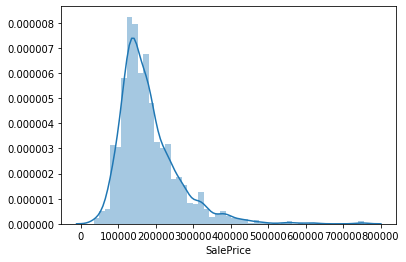

In [4]:
sns.distplot(train_data['SalePrice'])

From our data, we can see that the **sale prices** are right skewed. This is expected as most prices tend to fall near the median with some very expensive houses. 

To deal with this, we can consider a log-transformation to hopefully make the data normally distributed.

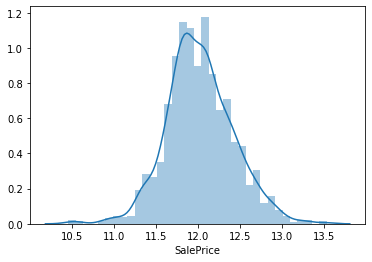

In [5]:
sns.distplot(np.log(train_data['SalePrice']))

Since logging proved to be useful, we can now assign the log data **(SalePrice_log)** as a new column and drop the old **(SalePrice)** column

In [6]:
train_data['SalePrice_log'] = np.log(train_data['SalePrice'])
train_data.drop('SalePrice', axis = 1, inplace = True)

**Now, let's work with the explanatory data**

In [7]:
train_data.shape

(1460, 81)

In [8]:
# Check for missing data in training dataset
missing_data = train_data.isnull().sum().sort_values(ascending=False)
print(missing_data[missing_data > 0])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [9]:
# Also check the test data
missing_data1 = test_data.isnull().sum().sort_values(ascending=False)
print(missing_data1[missing_data1 > 0])

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Exterior1st        1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64


**Comparing these variables with the data_description:**
- **NA means feature is not present**
    * PoolQC (Pool quality)
    * MiscFeature (Miscellaneous feature not covered in other categories)
    * Alley (Type of alley access to property)
    * Fence (Fence quality)
    * FireplaceQu (Fireplace quality)
    * GarageQu (Garage quality)
    * GarageCond (Garage condition)
    * GarageType (Garage location)
    * GarageYrBlt (Year garage was built)
    * GarageFinish (Interor finish of the garage)
    * BsmtExposure (Refers to walkout or garden level walls)
    * BsmtFinType2 (Rating of basement finished area; if multiple types)
    * BsmtFinType1 (Rating of basement finished area)
    * BsmtCond (Evaluates the general condition of the basement)
    * BsmtQual (Evaluates the height of the basement)


- **NA means missing data**
    * LotFrontage (Linear feet of street connected to property)
    * MasVnrArea (Masonry veneer area in square feet)
    * Electrical (Electrical system)
        + **From here on, missing data belongs to test dataset**
    * MSZoning (Identifies the general zoing classification of the sale)
    * BsmtHalfBath (Basement half bathrooms)
    * Utilities (Type of utilities available)
    * Functional (Home functionality; Assume typical unless deductions are warranted)
    * BsmtFullBath (Basement full bathrooms)
    * BsmtFinSF2 (Type 2 finished square feet)
    * BsmtFinSF1 (Type 1 finished square feet)
    * Exterior2nd (Exterior covering on house; if more than one material)
    * BsmtUnfSF (Unfinished square feet of basement area)
    * TotalBsmtSF (Total square feet of basement area)
    * SaleType (Type of sale)
    * Exterior1st (Exterior covering on house)
    * KitchenQual (Kitchen quality)
    * GarageArea (Size of garage in square feet)
    * GarageCars (Size of garage in car capacity)


**First, we will fill the columns where NA means the feature is not present**

In [10]:
no_feat = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageQual', 
           'GarageCond', 'GarageFinish', 'GarageType', 'GarageYrBlt', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']
            
for col in no_feat:
    train_data[col].fillna('None', inplace = True)
    test_data[col].fillna('None', inplace = True)

In [11]:
train_data.isnull().sum().sort_values(ascending=False)[0:10]

LotFrontage      259
MasVnrType         8
MasVnrArea         8
Electrical         1
SalePrice_log      0
Foundation         0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
ExterQual          0
dtype: int64

In [12]:
test_data.isnull().sum().sort_values(ascending=False)[0:20]

LotFrontage      227
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
Functional         2
BsmtHalfBath       2
Utilities          2
Exterior1st        1
Exterior2nd        1
GarageArea         1
KitchenQual        1
GarageCars         1
BsmtFinSF1         1
SaleType           1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
SaleCondition      0
ExterCond          0
dtype: int64

**Let's now move on to check the data type of all the variable with missing values**

In [13]:
train_data.dtypes[train_data.dtypes == 'object']

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageYrBlt      object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature     

In [14]:
train_data.dtypes[train_data.dtypes != 'object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice_log    float64
dtype: object

Based on the data type:
- Categorical data includes:
    * MasVnrType, Electrical, MSZoning, Functional, Utilities, Exterior1st, Exterior2nd, KitchenQual, SaleType
- Continuous data includes:
    * LotFrontage, MasVnrArea, BsmtFullBath, BsmtHalfBath, GarageArea, GarageCars, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF

**For simplificity:**

All missing data for categorical data will be filled in with the mode of that column.
All missing data for continuous data will be filled in with the mean of that column.

In [15]:
no_cat_feat = ['MasVnrType', 'Electrical', 'MSZoning', 'Functional', 'Utilities', 
               'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']

for col in no_cat_feat:
    train_data[col].fillna(train_data[col].mode()[0], inplace = True)
    # Note we are filling it with the mode of the training data, as it is likely to be more accurate (70/30 split)
    test_data[col].fillna(train_data[col].mode()[0], inplace = True)

In [16]:
no_cont_feat = ['LotFrontage', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 
               'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

for col in no_cont_feat:
    train_data[col].fillna(train_data[col].mean(), inplace = True)
    # Note we are filling it with the mode of the training data, as it is likely to be more accurate (70/30 split)
    test_data[col].fillna(train_data[col].mean(), inplace = True)

**Double checking to ensure all missing data has been filled**

In [17]:
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


**Now, let's remove continuous variables that have very low correlation**
- We can start off by limit our threshold to be > |0.3|

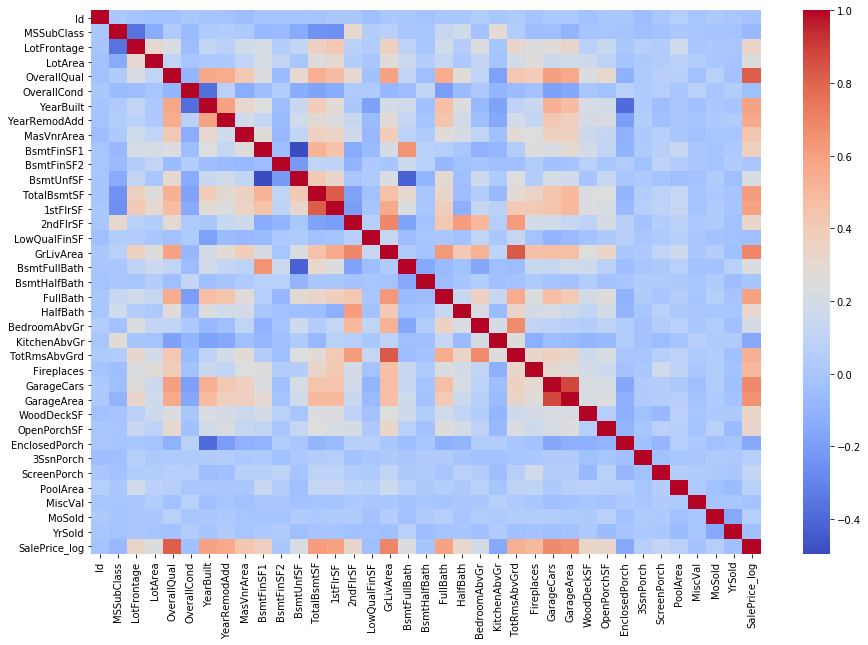

In [18]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.corr(), cmap = 'coolwarm')

In [19]:
train_data.corr()['SalePrice_log']

Id              -0.017942
MSSubClass      -0.073959
LotFrontage      0.336156
LotArea          0.257320
OverallQual      0.817184
OverallCond     -0.036868
YearBuilt        0.586570
YearRemodAdd     0.565608
MasVnrArea       0.429531
BsmtFinSF1       0.372023
BsmtFinSF2       0.004832
BsmtUnfSF        0.221985
TotalBsmtSF      0.612134
1stFlrSF         0.596981
2ndFlrSF         0.319300
LowQualFinSF    -0.037963
GrLivArea        0.700927
BsmtFullBath     0.236224
BsmtHalfBath    -0.005149
FullBath         0.594771
HalfBath         0.313982
BedroomAbvGr     0.209044
KitchenAbvGr    -0.147548
TotRmsAbvGrd     0.534422
Fireplaces       0.489449
GarageCars       0.680625
GarageArea       0.650888
WoodDeckSF       0.334135
OpenPorchSF      0.321053
EnclosedPorch   -0.149050
3SsnPorch        0.054900
ScreenPorch      0.121208
PoolArea         0.069798
MiscVal         -0.020021
MoSold           0.057329
YrSold          -0.037263
SalePrice_log    1.000000
Name: SalePrice_log, dtype: float64

From this table, we shall remove:
- **Threshold 0.2**:
    * MSSubClass, OverallCond, BsmtFinSF2, LowQualFinSF, BsmtHalfBath, KitchenAbvGr, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold
- **Threshold 0.3**:
    * MSSubClass, LotArea, OverallCond, BsmtFinSF2, BsmtUnfSF, LowQualFinSF, BsmtFullBath, BsmtHalfBath, BedroomAbvGr, KitchenAbvGr, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold

In [20]:
poor_cont_feat = ['MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 
                  'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', 
                  '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

for col in poor_cont_feat:
    train_data.drop(col, axis = 1, inplace = True)
    test_data.drop(col, axis = 1, inplace = True)

**GarageYrBlt** is also removed as it is very similar to **YearBuilt** which could result in multicollinearity problems

In [21]:
train_data.drop('GarageYrBlt', axis = 1, inplace = True)
test_data.drop('GarageYrBlt', axis = 1, inplace = True)

In [22]:
cat_feat = train_data.dtypes[train_data.dtypes == 'object'].index
cat_feat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [23]:
print(len(cat_feat))

43


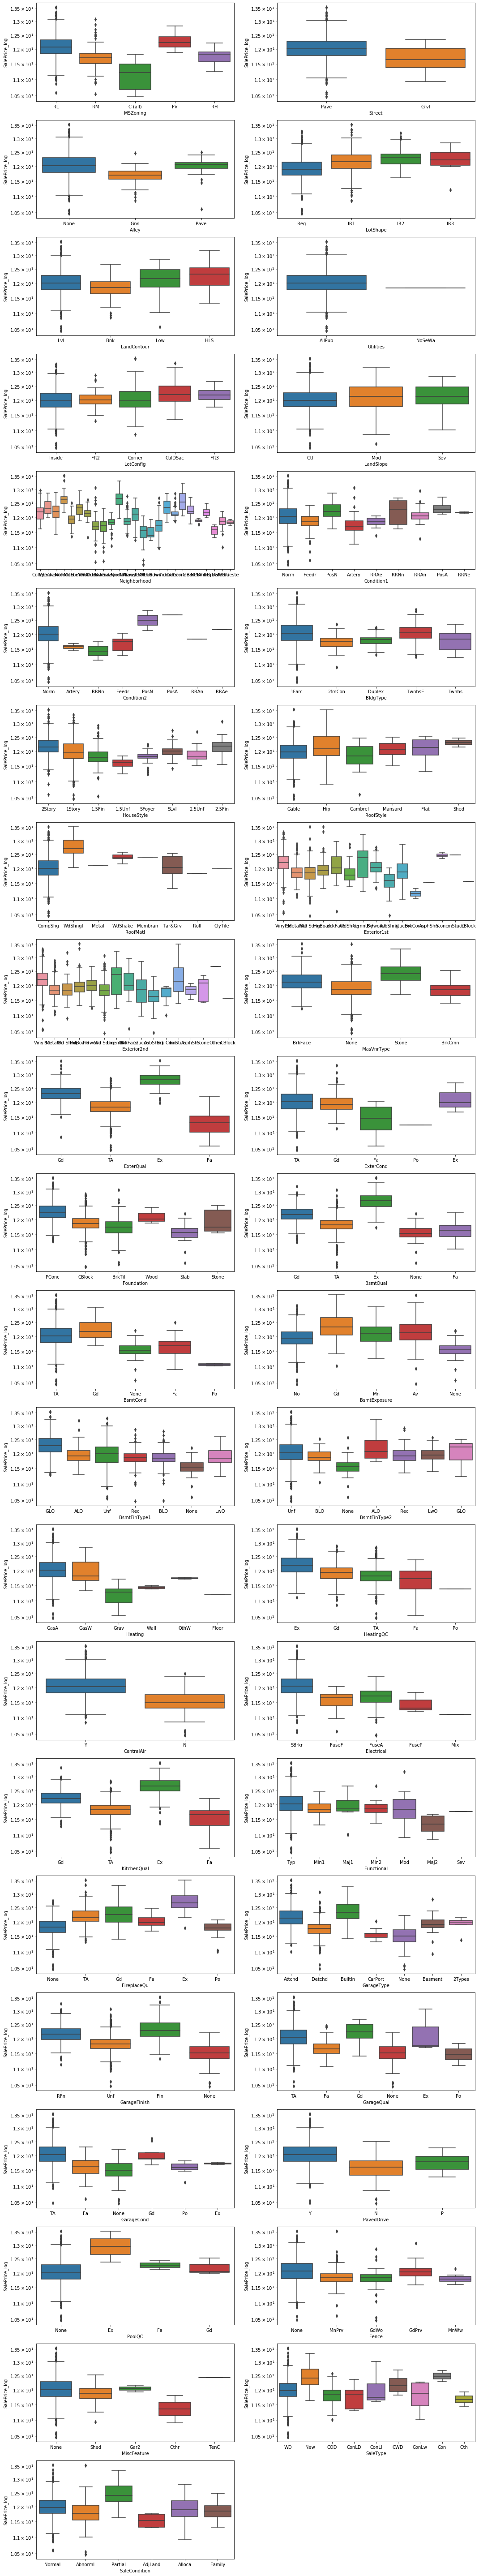

In [24]:
plt.figure(figsize=(15,80))

for i, c in enumerate(cat_feat, 1):
    plt.subplot(22,2,i) 
    g = sns.boxplot(x=c, y="SalePrice_log",data=train_data)
    g.set(yscale="log")

plt.tight_layout()    


From the graphs:
- Potentially important variables:
    * MSZoning, Neighborhood, Condition1, Condition2, HouseStyle, MasVnrType, ExterQual, BsmtQual, Heating, CentralAir, Electrical, KitchenQual, GarageType, PavedDrive, PoolQC, SaleType, SaleCondition
- Potentially less important variables:
    * Street, Alley, LotShape, LandContour, LotConfig, LandSlope, BldgType, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, ExterCond, Foundation, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond, Fence, MiscFeature
- Variables with very skewed data points:
    * Utilities
    
**Let's try to drop the less important an highly skewed variables to prevent overfitting of the model**

In [25]:
poor_cat_feat = ['Utilities', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 
                 'BldgType', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 
                 'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'MiscFeature']

for col in poor_cat_feat:
    train_data.drop(col, axis = 1, inplace = True)
    test_data.drop(col, axis = 1, inplace = True)

In [26]:
print(train_data.shape)
print(test_data.shape)

(1460, 37)
(1459, 36)


After removing the variables that are weakly correlated, we have about >50% of the explanatory variables left.

To further process the data, we can:
- Check for normality of the explanatory variables
- Scale the variables so that it will be more comparable.

But for now, let just get dummy variables for the categorical variables and train our model.

In [27]:
good_cat_feat = ['MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle', 'MasVnrType', 
                 'ExterQual', 'BsmtQual', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual', 
                 'GarageType', 'PavedDrive', 'PoolQC', 'SaleType', 'SaleCondition']

Before we do feature engineering, we should join the **train_data** and **test_data** together, so that the dummy variables generated would be similar for both datasets (In case there are unequal levels for each categorical variable)

In [28]:
train_data['SaleID'] = 1
test_data['SaleID'] = 0
comb_df = pd.concat([train_data, test_data])
comb_df.shape

(2919, 38)

In [29]:
df_dummies = pd.get_dummies(comb_df, columns = good_cat_feat, drop_first = True)
comb_df = pd.concat([comb_df, df_dummies], axis = 1)

for col in good_cat_feat:
    comb_df.drop(col, axis = 1, inplace = True)

In [30]:
print(comb_df.shape)
comb_df = comb_df.loc[:, ~comb_df.columns.duplicated()]
print(comb_df.shape)

(2919, 139)
(2919, 118)


Now, we can split the dataset back to train our model

In [31]:
train_df = comb_df[comb_df['SaleID'] == 1]
test_df = comb_df[comb_df['SaleID'] == 0]
print(train_df.shape)
print(test_df.shape)

(1460, 118)
(1459, 118)


In [32]:
train_df.drop('SaleID', axis = 1, inplace = True)

test_df.drop('SaleID', axis = 1, inplace = True)
test_df.drop('SalePrice_log', axis = 1, inplace = True)

C:\Users\resor\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Model Prediction using Linear Regression

In [33]:
# Importing libraries

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('SalePrice_log', axis = 1), 
                                                    train_df['SalePrice_log'], 
                                                    test_size = 0.20, random_state = 24)

In [35]:
lm = LinearRegression()

In [36]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
predictions = lm.predict(X_test)

In [38]:
print('R2:', round(r2_score(y_test, predictions), 3))
print('RMSE:', round(np.sqrt(mean_squared_error(y_test, predictions)), 3))

R2: 0.853
RMSE: 0.165


### Model Prediction using Random Forest

In [39]:
# Import libraries
from sklearn.ensemble import RandomForestRegressor

In [40]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [41]:
predictions1 = rfr.predict(X_test)

In [42]:
print('R2:', round(r2_score(y_test, predictions1), 3))
print('RMSE:', round(np.sqrt(mean_squared_error(y_test, predictions1)), 3))

R2: 0.878
RMSE: 0.151


**It seems that the random forest gives a slighter better prediction. So we will go with it for now.**

### Processing the test dataset

In [43]:
y_submission = rfr.predict(test_df)

Because we log transformed the data, we now need to back transform it

In [44]:
y_submission = np.exp(y_submission)

In [45]:
submission = pd.DataFrame({'Id': test_df.Id, 'SalePrice': y_submission})
submission.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved')

Your submission was successfully saved
